<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# EDA of the Radiant Earth Spot the Crop Challenge

In this notebook we will give a first look in the data of the `Radiant Earth Spot the Crop Challenge`.

In [1]:
from radiant_mlhub import Collection
import tarfile
import os
from pathlib import Path
import json
import ast

import datetime
import rasterio
from rasterio import merge
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit

from PIL import Image, ImageEnhance

from IPython.display import clear_output

from shapely.geometry import shape
from shapely.geometry import Polygon

import imageio


In [3]:
#competition_train_df = load_df('ref_south_africa_crops_competition_v1_train_labels')
#competition_test_df = load_df('ref_south_africa_crops_competition_v1_test_labels')

#competition_train_df.to_csv("data/assets_train.csv")
#competition_test_df.to_csv("data/assets_test.csv")

NameError: name 'competition_train_df' is not defined

## Loading the data

First we load the data that we have previously sumarized in a csv.

In [15]:
assets_train_df = pd.read_csv("data/data_fields/fields_train.csv", index_col= 0)
assets_train_df.reset_index(inplace = True)
#competition_test_df= pd.read_csv("competition_test.csv", index_col= 0)

In [2]:
assets_train_df = pd.read_csv("data/assets_train.csv")
#competition_test_df= pd.read_csv("competition_test.csv", index_col= 0)

In [17]:
assets_train_df.head()

,tile_id,datetime,satellite_platform,asset,file_path,geometry,date,month,dayofyear
0,2587,NaN,NaN,documentation,/home/jupyter/NF-Capstone-Crop-Classification/...,NaN,NaN,NaN,NaN
1,2587,NaN,NaN,field_ids,/home/jupyter/NF-Capstone-Crop-Classification/...,NaN,NaN,NaN,NaN
2,2587,NaN,NaN,field_info_train,/home/jupyter/NF-Capstone-Crop-Classification/...,NaN,NaN,NaN,NaN
3,2587,NaN,NaN,labels,/home/jupyter/NF-Capstone-Crop-Classification/...,NaN,NaN,NaN,NaN
4,2587,NaN,NaN,raster_values,/home/jupyter/NF-Capstone-Crop-Classification/...,NaN,NaN,NaN,NaN


In [24]:
assets_train_df.iloc[7,5]

'2017-04-06'

In [21]:
def gif_maker(tile_id, kind):
    
    foto = {"natural": ["B04", "B03", "B02"],
            "color infrared": ["B08", "B04", "B03"],
            "SWIR": ["B12", "B8A", "B04"],
            "agriculture": ["B11", "B08", "B02"],
            "geology": ["B12", "B11", "B02"],
            "bathymetric": ["B04", "B03", "B01"],
            "vegetation_idx": ["B08", "B04"],     #(B8-B4)/(B8+B4)
            "moisture_idx": ["B8A", "B11"]}   #(B8A-B11)/(B8A+B11)         

    days_of_year = assets_train_df.query('tile_id == @tile_id & asset == "B03"')['dayofyear'].unique()

    filenames = []

    for dayofyear in days_of_year:

        fig, ax = plt.subplots(figsize=(10,10))

        pic = np.empty((256, 256, 3), dtype='uint8')

        # create file name and append it to a list
        filename = f'{dayofyear}.png'
        filenames.append(filename)
        
            
        if kind == "vegetation_idx" or kind == "moisture_idx":
            
            ### 1st channel
            chan_rio = rasterio.open(assets_train_df[(assets_train_df.tile_id == tile_id) & (assets_train_df.asset == foto[kind][0]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4])
            pic[:,:,0] = chan_rio.read()

            ### 2nd channel
            chan_rio = rasterio.open(assets_train_df[(assets_train_df.tile_id == tile_id) & (assets_train_df.asset == foto[kind][1]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4])
            pic[:,:,1] = chan_rio.read()
            
            picture = (pic[:,:,0] - pic[:,:,1]/ (pic[:,:,0] + pic[:,:,1])).reshape(256,256)
            
            ax = sns.heatmap(picture, square=True,  cmap="YlGnBu")
            
        else:
            ### red channel
            chan_rio = rasterio.open(assets_train_df[(assets_train_df.tile_id == tile_id) & (assets_train_df.asset == foto[kind][0]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4])
            pic[:,:,0] = chan_rio.read()

            ### green channel
            chan_rio = rasterio.open(assets_train_df[(assets_train_df.tile_id == tile_id) & (assets_train_df.asset == foto[kind][1]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4])
            pic[:,:,1] = chan_rio.read()

            ### blue channel
            chan_rio = rasterio.open(assets_train_df[(assets_train_df.tile_id == tile_id) & (assets_train_df.asset == foto[kind][2]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4])
            pic[:,:,2] = chan_rio.read()

            # create pillow image
            im = Image.fromarray(pic, mode = "RGB")

            #image brightness enhancer
            enhancer = ImageEnhance.Brightness(im)

            factor = 3 #gives original image
            im_output = enhancer.enhance(factor)

            ax.imshow(im_output)
        
        #ax.text(220,20, f"{dayofyear}", fontsize = 30, color = "w", fontweight = "black")
        #ax.text(20,20, f"{tile_id}", fontsize = 30, color = "w", fontweight = "black")

        # save frame
        #plt.savefig(filename)
        #plt.close()#
        ax.axis('off');
        ax.legend("off")
    
        plt.savefig(f'{tile_id}_{dayofyear}_' + '_'.join(kind) + '.png', dpi=None, facecolor='auto', edgecolor='auto',orientation='portrait',transparent=True)
        
      
    # build gif
    with imageio.get_writer(f'{tile_id}_{kind}.gif', mode='I', duration = 0.75) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove files
    for filename in set(filenames):
        os.remove(filename)


"        \n    # build gif\n    with imageio.get_writer(f'{tile_id}_{kind}.gif', mode='I', duration = 0.75) as writer:\n        for filename in filenames:\n            image = imageio.imread(filename)\n            writer.append_data(image)\n\n    # Remove files\n    for filename in set(filenames):\n        os.remove(filename)\n"

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


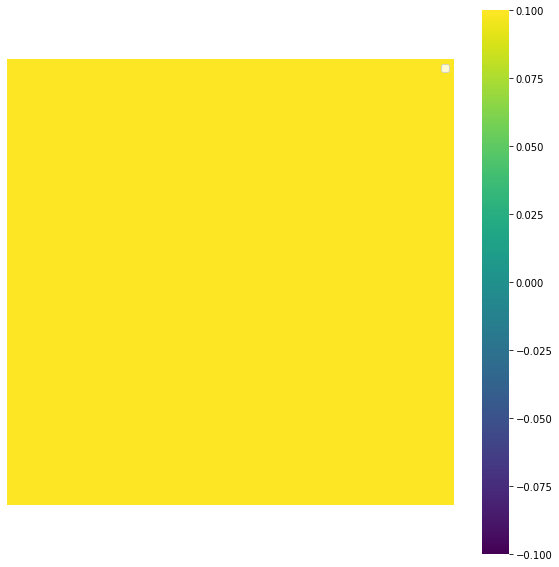

In [22]:
#gif_maker(500, "natural")
#gif_maker(500, "color infrared")
#gif_maker(500, "SWIR")
#gif_maker(500, "agriculture")
#gif_maker(500, "geology")
#gif_maker(500, "bathymetric")
#gif_maker(127, "vegetation_idx")
#gif_maker(500, "moisture_idx")

[[30 30 32 ... 41 51 65]
 [31 33 33 ... 43 51 63]
 [33 35 33 ... 49 55 62]
 ...
 [74 74 75 ... 24 28 37]
 [75 74 78 ... 24 27 33]
 [79 76 76 ... 21 26 31]]


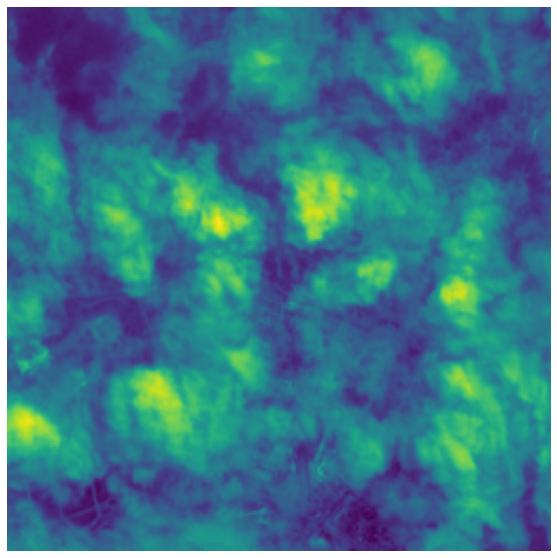

In [25]:
foto = {"natural": ["B04", "B03", "B02"],
        "color infrared": ["B08", "B04", "B03"],
        "SWIR": ["B12", "B8A", "B04"],
        "agriculture": ["B11", "B08", "B02"],
        "geology": ["B12", "B11", "B02"],
        "bathymetric": ["B04", "B03", "B01"],
        "vegetation_idx": ["B08", "B04"],     #(B8-B4)/(B8+B4)
        "moisture_idx": ["B8A", "B11"]}   #(B8A-B11)/(B8A+B11)         

dayofyear = 94
tile_id = 1824
kind = "vegetation_idx"

fig, ax = plt.subplots(figsize=(10,10))

pic = np.empty((256, 256, 1), dtype='uint8')

### 1st channel
chan_rio = rasterio.open(assets_train_df[(assets_train_df.tile_id == tile_id) & (assets_train_df.asset == "B04") & (assets_train_df.dayofyear == dayofyear)].iloc[0,4])
pic[:,:,0] = chan_rio.read()

print(pic[:,:,0])

### 2nd channel
#chan_rio = rasterio.open(assets_train_df[(assets_train_df.tile_id == tile_id) & (assets_train_df.asset == foto[kind][1]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4])
#pic[:,:,1] = chan_rio.read()

picture = np.empty((256*256, 1), dtype='uint8')


#picture = ((pic[:,:,0] - pic[:,:,1])/ (pic[:,:,0] + pic[:,:,1])).reshape(256,256)

#ax = sns.heatmap(picture, square=True,  cmap="viridis", cbar = True)
ax.imshow(pic)

#ax.text(220,20, f"{dayofyear}", fontsize = 30, color = "w", fontweight = "black")
#ax.text(20,20, f"{tile_id}", fontsize = 30, color = "w", fontweight = "black")

# save frame
#plt.savefig(filename)
#plt.close()#
ax.axis('off');

#plt.savefig(f'{tile_id}_{dayofyear}_{kind}'+ '.png', dpi=None, facecolor='auto', edgecolor='auto',orientation='portrait',transparent=True)


In [26]:
mask = np.empty((256, 256), dtype='uint8')
mask[:,:] = pic[:,:,0]

mask_sum = np.count_nonzero(mask)

if mask_sum/(256*256) > 0.8:
    print(1)
else:
    print(0)

1


In [53]:
item = json.load(open("/home/jupyter/NF-Capstone-Crop-Classification/ref_south_africa_crops_competition_v1_train_source_s2/ref_south_africa_crops_competition_v1_train_source_s2_0323_2017_11_27/stac.json"))

for asset in item["assets"].keys():
    name = item["assets"][asset]["eo:bands"][0]["common_name"]
    
    print(f"{asset}: {name}")

B01: Coastal aerosol
B02: Blue
B03: Green
B04: Red
B05: Vegetation red edge
B06: Vegetation red edge
B07: Vegetation red edge
B08: NIR
B09: Water Vapour
B11: SWIR
B12: SWIR
B8A: Narrow NIR
CLM: Cloud Mask


In [30]:
dict(dict(item)["assets"])["B01"]

{'eo:bands': [{'common_name': 'Coastal aerosol', 'gsd': 10, 'name': 'B01'}],
 'href': 'B01.tif',
 'type': 'image/tiff'}

In [31]:
item = json.load(open("ref_south_africa_crops_competition_v1_test_labels/_common/raster_values.json"))
item

{'0': 'No Data',
 '1': 'Lucerne/Medics',
 '2': 'Planted pastures (perennial)',
 '3': 'Fallow',
 '4': 'Wine grapes',
 '5': 'Weeds',
 '6': 'Small grain grazing',
 '7': 'Wheat',
 '8': 'Canola',
 '9': 'Rooibos'}

## Cloud Check

tiles = np.sort(competition_train_df.query('dayofyear == dayofyear & asset == "B03"')['tile_id'].unique())
day_per_pic = {}
i = 0

for tile in tiles:
    day_per_pic[tile] = competition_train_df.query(f'tile_id == {tile} & asset == "B03"')['dayofyear'].nunique()
    clear_output(wait=True)
    i += 1
    print(i)
    


In [58]:
assets_train_df.query('tile_id == 1099 & asset == "labels" & dayofyear == 204.0')

,tile_id,datetime,satellite_platform,asset,file_path,geometry,date,month,dayofyear


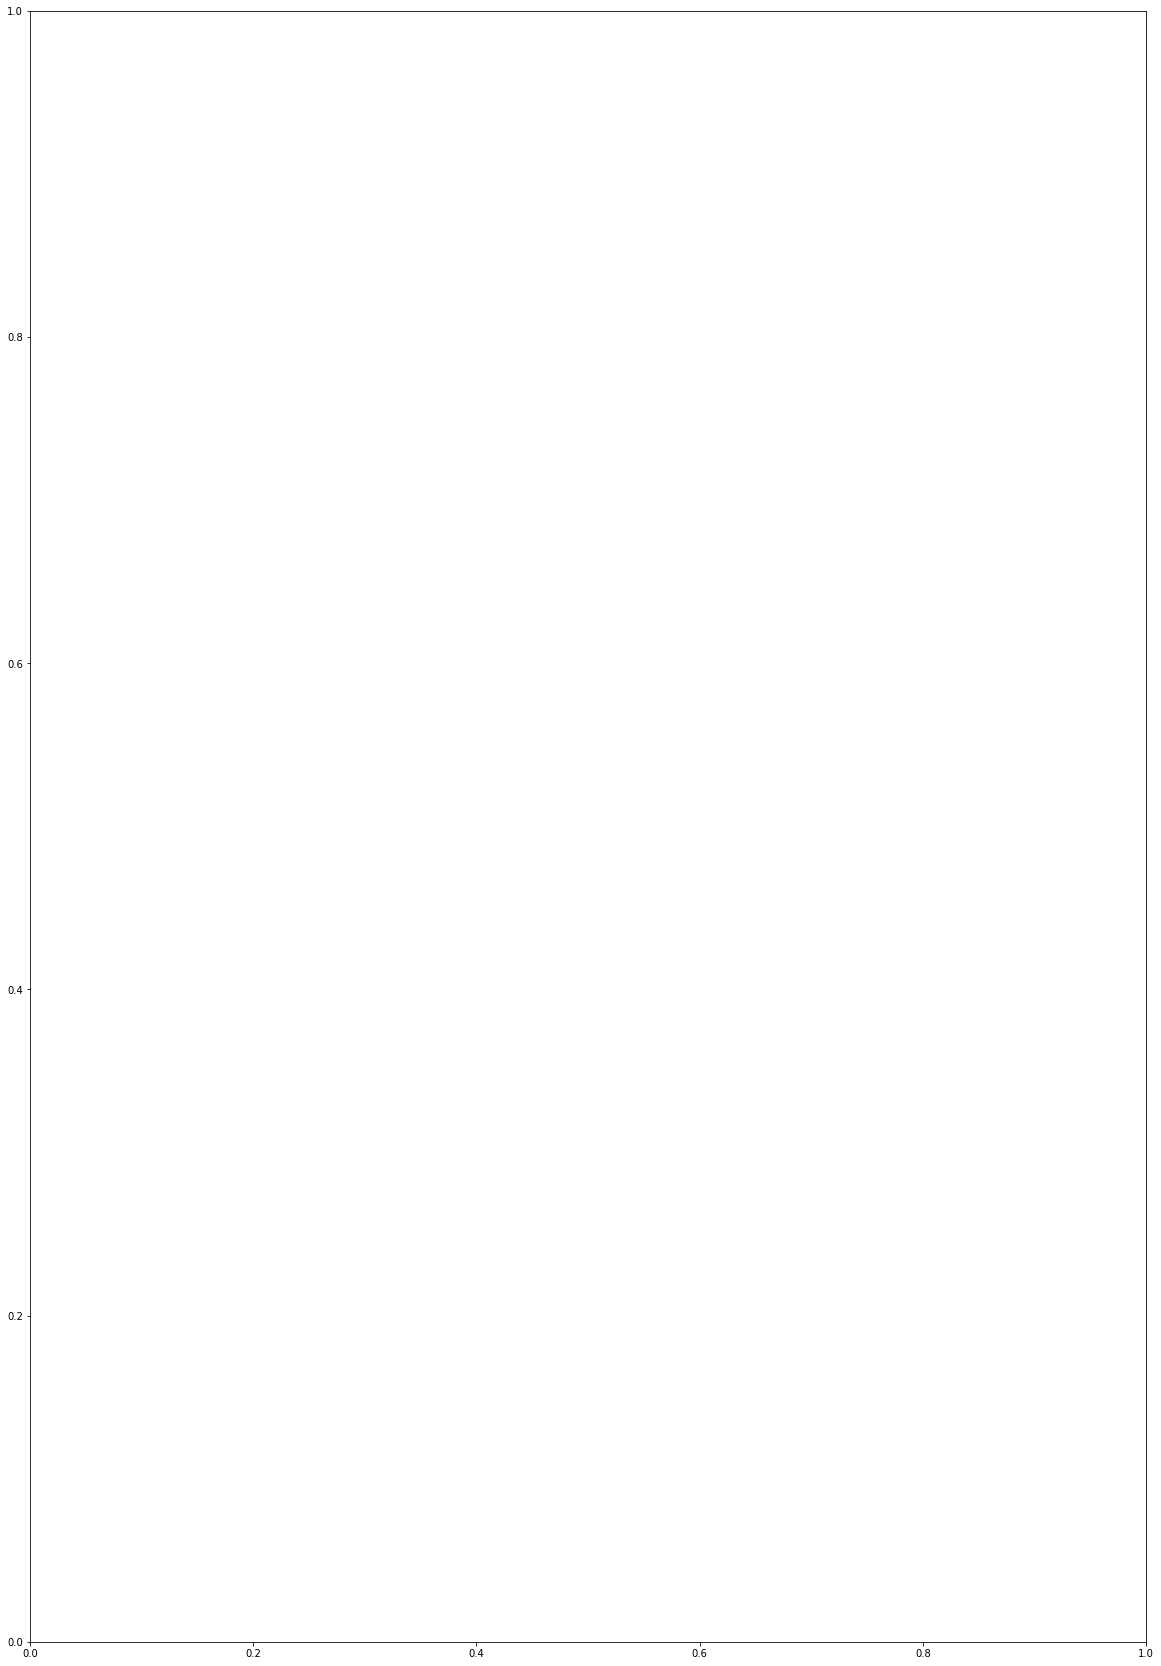

In [7]:
tile_id = 1099
days_of_year = 204.0

fig, axs = plt.subplots(figsize=[20,30])

pic = np.empty((256, 256, 3), dtype='uint8')

chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B04" & dayofyear == @dayofyear').iloc[0,4])
pic[:,:,0] = chan_rio.read()

### green channel
chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B03" & dayofyear == @dayofyear').iloc[0,4])
pic[:,:,1] = chan_rio.read()

### blue channel
chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B02" & dayofyear == @dayofyear').iloc[0,4])
pic[:,:,2] = chan_rio.read()
    
    
# create pillow image
im = Image.fromarray(pic)

#image brightness enhancer
enhancer = ImageEnhance.Brightness(im)

factor = 3 #gives original image
im_output = enhancer.enhance(factor)

ax.text(20,20, f"{dayofyear}", fontsize = 10, color = "g", fontweight = "black")
ax.text(220,20, f"{tile_id}", fontsize = 10, color = "g", fontweight = "black")

ax.imshow(im_output)

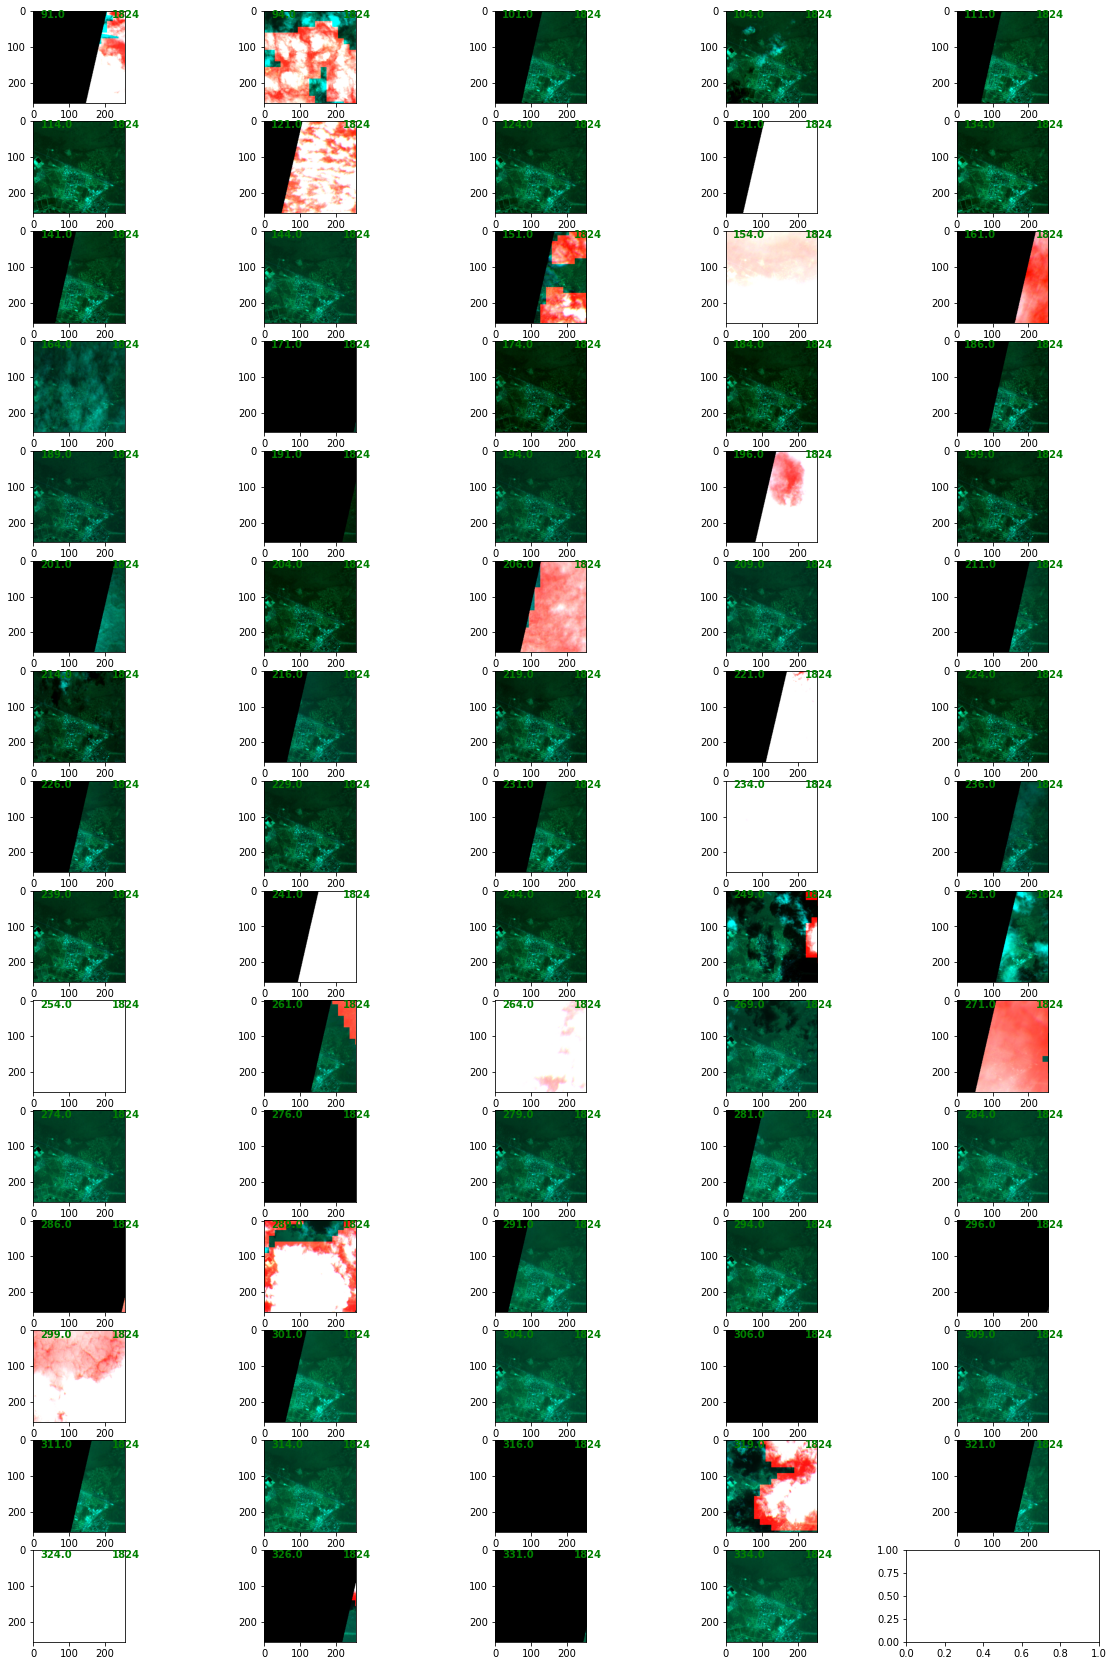

In [87]:
tile_id = 1824
days_of_year = assets_train_df.query('tile_id == @tile_id & asset == "B01"')['dayofyear'].unique()

ncol = 5
nrow = int(len(days_of_year)/ncol) + 1 

fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=[20,30])
axs = axs.flatten()

for dayofyear, ax in zip (days_of_year, axs):

    pic = np.empty((256, 256, 3), dtype='uint8')
    
    ### red channel
    chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "CLM" & dayofyear == @dayofyear').iloc[0,4])
    pic[:,:,0] = chan_rio.read()
    
    ### green channel
    chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B03" & dayofyear == @dayofyear').iloc[0,4])
    pic[:,:,1] = chan_rio.read()
    
    ### blue channel
    chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B02" & dayofyear == @dayofyear').iloc[0,4])
    pic[:,:,2] = chan_rio.read()
    
    # create pillow image
    im = Image.fromarray(pic)

    #image brightness enhancer
    enhancer = ImageEnhance.Brightness(im)
    
    factor = 3 #gives original image
    im_output = enhancer.enhance(factor)
    
    ax.text(20,20, f"{dayofyear}", fontsize = 10, color = "g", fontweight = "black")
    ax.text(220,20, f"{tile_id}", fontsize = 10, color = "g", fontweight = "black")
    
    ax.imshow(im_output)

In [ ]:
def cloud_finder(tile_id, dayofyear, threshold = 0.2):
    
    """
    This function classifies the picture as useful = 1 or not useful = 0, regarding the rate of clouds on the band "CLM".    
    """
    
    mask = np.empty((256, 256), dtype='uint8')
    chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "CLM" & dayofyear == @dayofyear').iloc[0,4])
    mask[:,:] = chan_rio.read()/255
    
    mask_sum = np.sum(mask)
    
    if mask_sum/(256*256) < threshold:
        return 1
    else:
        return 0
    
cloud_finder(6,171)


In [ ]:
"""
This cell takes very long
"""

tiles = np.sort(competition_train_df.query('asset == "CLM"')['tile_id'].unique())

day_per_tile = []
day_sunny = []
i = 0

for tile in tiles[2400:]:
    
    day_per_tile[tile] = assets_train_df.query(f'tile_id == {tile} & asset == "CLM"')['dayofyear'].unique()
    day_sunny[tile] = []
    
    clear_output(wait=True)
    i += 1
    print(i)

    for idx, dayofyear in enumerate(day_per_tile[tile]):
        
        if cloud_finder(tile,dayofyear, 0.2) == 1:
                day_sunny[tile].append(dayofyear)     
           
   

In [ ]:
rate_sunny = {tile :len(day_sunny[tile])/len(day_per_tile[tile]) for tile in tiles}



In [ ]:
rows = []

for tile in tiles:
    
    rows.append([
        str(tile),
        day_per_tile[tile],
        day_sunny[tile],
        rate_sunny[tile],
    ])
    
df_sunny = pd.DataFrame(rows, columns = ["tile_id", "all_days", "sunny_days", "sun_rate"])
df_sunny.to_csv("train_sunny_days.csv")
df_sunny.head(20)

## MultiTile plot

In [9]:
def big_pic_maker(kind, dayofyear):
    
    foto = {"natural": ["B04", "B03", "B02"],
            "color infrared": ["B08", "B04", "B03"],
            "SWIR": ["B12", "B8A", "B04"],
            "agriculture": ["B11", "B08", "B02"],
            "geology": ["B12", "B11", "B02"],
            "bathymetric": ["B04", "B03", "B01"],
            "NDVI": ["B08", "B04"],     #(B8-B4)/(B8+B4)
            "moisture_idx": ["B8A", "B11"]}   #(B8A-B11)/(B8A+B11)         

    #tiles = [2237,1278,1970,2403,657,2396,2600,496,1104,1080,1029,925,2177,2338,1245,1278,551] #
    tiles = [1870,705,1824,2579] #[1655, 820,1372,531,578,1870,2550,242,705,1824,2579,262,1555,1720,2034,1414,1845,1405,1666,1816,415,2046,875] #
    filenames = []

    fig, ax = plt.subplots(figsize=(20,20))

    # create file name and append it to a list
    filename = f'{dayofyear}.png'
    filenames.append(filename)
        
    datasets_R = []
    datasets_G = []
    datasets_B = []
    label_rio = []
    
    for i in range(len(tiles)):
        
        clear_output(wait=True)
        print(i)
        ### red channel
        datasets_R.append(rasterio.open(assets_train_df[(assets_train_df.tile_id == tiles[i]) & (assets_train_df.asset == foto[kind][0]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4]))

        ### green channel
        datasets_G.append(rasterio.open(assets_train_df[(assets_train_df.tile_id == tiles[i]) & (assets_train_df.asset == foto[kind][1]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4]))
        
        if kind == "NDVI" or kind == "moisture_idx":
            pass
        else:
            ### blue channel
            datasets_B.append(rasterio.open(assets_train_df[(assets_train_df.tile_id == tiles[i]) & (assets_train_df.asset == foto[kind][2]) & (assets_train_df.dayofyear == dayofyear)].iloc[0,4]))

        label_rio.append(rasterio.open(assets_train_df[(assets_train_df.tile_id == tiles[i]) & (assets_train_df.asset == "labels")].iloc[0,4]))
    
    
        
    chan_bigR_rio, output_transform_R = rasterio.merge.merge(datasets_R) 
    chan_bigG_rio, output_transform_G = rasterio.merge.merge(datasets_G) 
    if kind != "NDVI" and kind != "moisture_idx":
        chan_bigB_rio, output_transform_B = rasterio.merge.merge(datasets_B) 
    chan_label_rio, output_transform_label = rasterio.merge.merge(label_rio) 
    
    
    #print(type(chan_bigR_rio))
                                                                                
    pic = np.empty((chan_bigR_rio.shape[1], chan_bigR_rio.shape[2], len(foto[kind])), dtype='uint8')
    
    pic[:,:,0] = chan_bigR_rio
    pic[:,:,1] = chan_bigG_rio
    print(type(pic))
    if kind != "NDVI" and kind != "moisture_idx":
        pic[:,:,2] = chan_bigB_rio

    
    if kind != "NDVI" and kind != "moisture_idx":
    
        # create pillow image
        im = Image.fromarray(pic, mode = "RGB")

        print(type(im))
        #image brightness enhancer
        enhancer = ImageEnhance.Brightness(im)

        factor = 3 #gives original image
        im_output = enhancer.enhance(factor)

        ax.imshow(im_output)
    else:
        
        picture = np.empty(((chan_bigR_rio.shape[1])* (chan_bigR_rio.shape[2]), 1), dtype='uint8')
        picture = ((pic[:,:,0] - pic[:,:,1])/ (pic[:,:,0] + pic[:,:,1])).reshape((chan_bigR_rio.shape[1]), (chan_bigR_rio.shape[2]))
        ax = sns.heatmap(picture, square=True,  cmap="Spectral",vmin= -0.2, vmax= 1) # , vmin= -0.2, vmax= 1

    #chan_label_rio_masked =np.ma.masked_where((chan_label_rio[0] < 1), chan_label_rio[0])
    #ax.imshow(chan_label_rio_masked, alpha=1, cmap='YlGnBu')

    #ax.text(220,20, f"{dayofyear}", fontsize = 30, color = "w", fontweight = "black")
    #ax.text(20,20, f"{tile_id}", fontsize = 30, color = "w", fontweight = "black")
    ax.axis("off")
    
    # save frame
    plt.savefig(f"day_{dayofyear}_big_{kind}", transparent = True)
    plt.show()
    

In [36]:
tiles = assets_train_df.query('dayofyear == 91 & asset == "B03"')['tile_id'].unique()
tiles

array([2587, 1302, 1130, ...,   99, 1379, 2198])

3
<class 'numpy.ndarray'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide


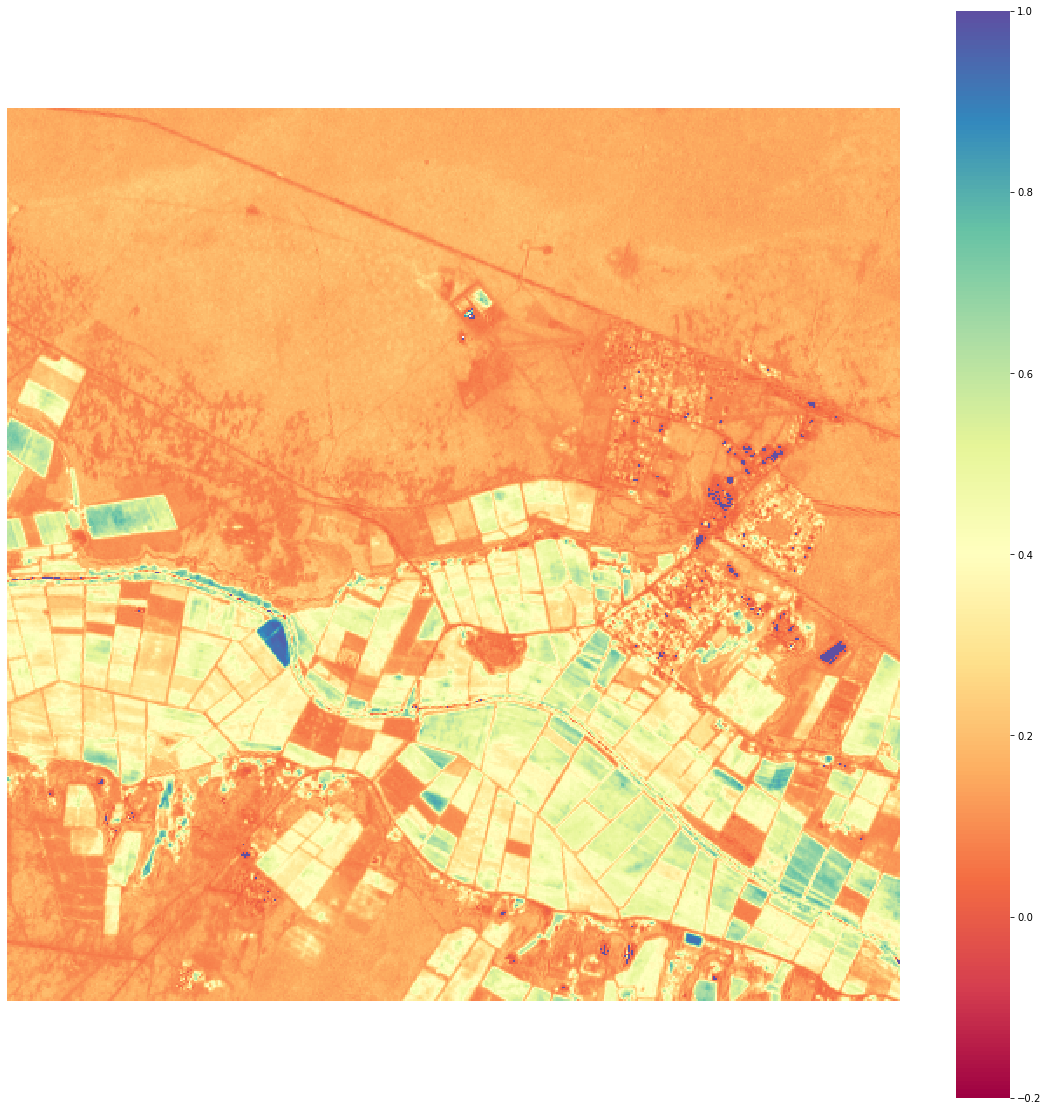

In [10]:
from rasterio import merge

big_pic_maker("NDVI", 334)

In [4]:


tiles = np.sort(assets_train_df.query('asset == "CLM"')['tile_id'].unique())


# create file name and append it to a list

label_rio = []

for i in range(len(tiles)):

    clear_output(wait=True)
    print(i)

    label_rio.append(rasterio.open(assets_train_df[(assets_train_df.tile_id == tiles[i]) & (assets_train_df.asset == "labels")].iloc[0,4]))    

chan_label_rio, output_transform_label = rasterio.merge.merge(label_rio) 

#print(type(chan_bigR_rio))                                                                         



2649


In [5]:
fig, ax = plt.subplots(figsize=(20,20))

#chan_label_rio_masked =np.ma.masked_less( chan_label_rio[0], 1)
ax.imshow(chan_label_rio[0,:1000,:1000], alpha=1, cmap='YlGnBu')

#ax.text(220,20, f"{dayofyear}", fontsize = 30, color = "w", fontweight = "black")
#ax.text(20,20, f"{tile_id}", fontsize = 30, color = "w", fontweight = "black")
ax.axis("off")

# save frame
plt.savefig(f"labels_big.png", transparent = True)
plt.close()
    

In [6]:
ndvi_index = np.arange(20)/5 -1

upper_limit = 1
lower_limit = -0.2

ndvi_index = np.where(ndvi_index > lower_limit, ndvi_index , lower_limit)
ndvi_index = np.where(ndvi_index < upper_limit, ndvi_index , upper_limit)

In [7]:
ndvi_index

array([-0.2, -0.2, -0.2, -0.2, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ])